In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

c:\Users\Ardian\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
os.listdir('C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan')

['Batik Buketan',
 'Batik Cendrawasih',
 'Batik Ceplok',
 'Batik Corak Insang',
 'Batik Dayak',
 'Batik Gunungan',
 'Batik Ikat Celup',
 'Batik Kawung',
 'Batik Lereng',
 'Batik Megamendung',
 'Batik Nitik',
 'Batik Parang',
 'Batik Prada',
 'Batik Sekar',
 'Batik Sidoluhur',
 'Batik Truntum',
 'Batik Tumpal',
 'model.tflite',
 'test',
 'train',
 'val']

In [4]:
directory = 'C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan'

### Define Training, Validation, and Testing Directories

In [6]:
train_dir = os.path.join(directory, 'train')
val_dir = os.path.join(directory, 'val')
test_dir = os.path.join(directory, 'test')

## Data Augmentation
In this section, we define data augmentation for the training dataset using the `ImageDataGenerator` class from TensorFlow. Various transformations such as rescaling, rotation, width shift, height shift, shear, zoom, horizontal flip, and vertical flip are applied to the training images. 

For the validation dataset, only rescaling is applied to normalize the pixel values.

The augmented training and validation datasets are then loaded using the `flow_from_directory` method, specifying the target size, batch size, and class mode.

In [7]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_dataset = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1656 images belonging to 17 classes.
Found 430 images belonging to 17 classes.


## Load and Preprocess an Example Image

In this section, we load an example image from the training dataset, preprocess it by resizing it to the target size of (224, 224), and convert it to an array. This array will be used for further processing and model predictions.

In [8]:
# Load an example image
img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

# Convert the image to an array
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (224, 224, 3)


## Class Distribution

In this section, we calculate and display the number of images in each class for the training, validation, and testing datasets. This helps us understand the distribution of the dataset and ensure that it is balanced.

In [9]:
train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
print("Number of images in each class for the training dataset:")
for cls, count in train_class_counts.items():
    print(f"{cls}: {count}")

val_class_counts = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in os.listdir(val_dir)}
print("\nNumber of images in each class for the validation dataset:")
for cls, count in val_class_counts.items():
    print(f"{cls}: {count}")

test_class_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)}
print("\nNumber of images in each class for the testing dataset:")
for cls, count in test_class_counts.items():
    print(f"{cls}: {count}")

Number of images in each class for the training dataset:
Batik Buketan: 98
Batik Cendrawasih: 98
Batik Ceplok: 98
Batik Corak Insang: 98
Batik Dayak: 98
Batik Gunungan: 98
Batik Ikat Celup: 90
Batik Kawung: 98
Batik Lereng: 97
Batik Megamendung: 98
Batik Nitik: 97
Batik Parang: 98
Batik Prada: 98
Batik Sekar: 98
Batik Sidoluhur: 98
Batik Truntum: 98
Batik Tumpal: 98

Number of images in each class for the validation dataset:
Batik Buketan: 28
Batik Cendrawasih: 28
Batik Ceplok: 16
Batik Corak Insang: 28
Batik Dayak: 26
Batik Gunungan: 28
Batik Ikat Celup: 20
Batik Kawung: 28
Batik Lereng: 16
Batik Megamendung: 28
Batik Nitik: 16
Batik Parang: 28
Batik Prada: 28
Batik Sekar: 28
Batik Sidoluhur: 28
Batik Truntum: 28
Batik Tumpal: 28

Number of images in each class for the testing dataset:
Batik Buketan: 14
Batik Cendrawasih: 14
Batik Ceplok: 8
Batik Corak Insang: 14
Batik Dayak: 13
Batik Gunungan: 14
Batik Ikat Celup: 10
Batik Kawung: 14
Batik Lereng: 8
Batik Megamendung: 14
Batik Nitik:

In [ ]:
train_df = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Train Count'])
val_df = pd.DataFrame(list(val_class_counts.items()), columns=['Class', 'Validation Count'])
test_df = pd.DataFrame(list(test_class_counts.items()), columns=['Class', 'Test Count'])

df_counts = train_df.merge(val_df, on='Class').merge(test_df, on='Class')

df_counts

,Class,Train Count,Validation Count,Test Count
0,Batik Buketan,98,28,14
1,Batik Cendrawasih,98,28,14
2,Batik Ceplok,98,16,8
3,Batik Corak Insang,98,28,14
4,Batik Dayak,98,26,13
5,Batik Gunungan,98,28,14
6,Batik Ikat Celup,90,20,10
7,Batik Kawung,98,28,14
8,Batik Lereng,97,16,8
9,Batik Megamendung,98,28,14


## CNN Model Architecture using Functional API and Transfer Learning

In this section, we define the architecture of our model using the MobileNet base model with pre-trained weights. We exclude the top layers and add custom layers on top of the base model. The custom layers include Global Average Pooling, Dense layers with ReLU activation, Dropout layers for regularization, and a final Dense layer with softmax activation for classification.

We then create the final model, freeze the layers of the base model to prevent them from being trained, and compile the model with the Adam optimizer and categorical cross-entropy loss. We also define callbacks for early stopping and learning rate reduction.

Finally, we display the summary of the model architecture.

In [ ]:
# Get the list of classes from the training dataset
classes = list(train_class_counts.keys())

# Load the MobileNet model with pre-trained weights, excluding the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,938,961 (18.84 MB)

 Trainable params: 1,710,097 (6.52 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

## Train the Model

In this section, we train the model using the training dataset and validate it using the validation dataset. We use the `fit` method to train the model for 50 epochs, with early stopping and learning rate reduction callbacks to prevent overfitting and optimize the learning process.

After the initial training, we unfreeze the last 20 layers of the base model to allow fine-tuning. We then recompile the model with a lower learning rate and continue training for another 50 epochs.

In [12]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\Ardian\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.1016 - loss: 3.3829

c:\Users\Ardian\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1020 - loss: 3.3756 - val_accuracy: 0.4302 - val_loss: 2.3163 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.2549 - loss: 2.3658 - val_accuracy: 0.6628 - val_loss: 1.4704 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4285 - loss: 1.7916 - val_accuracy: 0.7581 - val_loss: 0.9584 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5404 - loss: 1.4244 - val_accuracy: 0.7651 - val_loss: 0.7936 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6226 - loss: 1.2039 - val_accuracy: 0.8140 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6684 - loss: 1.0959 - val_accuracy: 0.8070 - val_loss: 0.6635 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6903 - loss: 0.9468 - val_accuracy: 0.8070 - va

## Training and Validation Accuracy and Loss

We visualize the training and validation accuracy and loss over the epochs. The plots help us understand how well the model is performing on the training and validation datasets during the training process.

We plot the training and validation accuracy on the left and the training and validation loss on the right. The red lines represent the training metrics, while the blue lines represent the validation metrics.

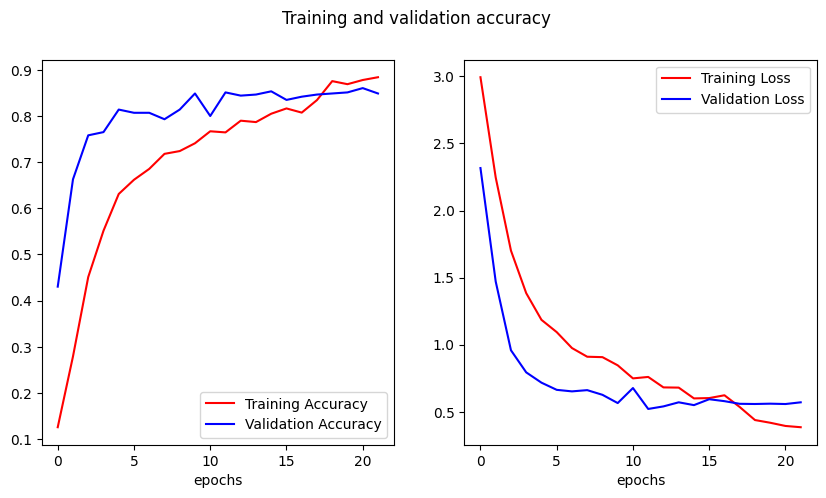

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Test The Model

We define data augmentation for the testing dataset using the `ImageDataGenerator` class from TensorFlow. Only rescaling is applied to normalize the pixel values.

We then load the test dataset using the `flow_from_directory` method, specifying the target size, batch size, and class mode. The images are not shuffled to maintain the order for evaluation.

Next, we use the trained model to predict the classes for the test dataset. The predicted classes are obtained by taking the argmax of the prediction probabilities.

Finally, we display the prediction results for each image in the test set, showing the image path, predicted class, and actual class.

In [ ]:
# Data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset
test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Predict the classes for the test dataset
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get the class labels
class_labels = list(test_dataset.class_indices.keys())

# Display the prediction results for each image in the test set
for i, (image_path, predicted_class, actual_class) in enumerate(zip(test_dataset.filepaths, predicted_classes, test_dataset.classes)):
    print(f"Image: {image_path}")
    print(f"Predicted class: {class_labels[predicted_class]}")
    print(f"Actual class: {class_labels[actual_class]}")
    print()

Found 215 images belonging to 17 classes.


215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step
Image: C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan\test\Batik Buketan\BatikBuketan (1).jpg
Predicted class: Batik Buketan
Actual class: Batik Buketan

Image: C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan\test\Batik Buketan\BatikBuketan (2).jpg
Predicted class: Batik Buketan
Actual class: Batik Buketan

Image: C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan\test\Batik Buketan\BatikBuketan (8).jpg
Predicted class: Batik Buketan
Actual class: Batik Buketan

Image: C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan\test\Batik Buketan\BatikBuketan (9).jpg
Predicted class: Batik Buketan
Actual class: Batik Buketan

Image: C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan\test\Batik Buketan\buketan_269.jpg
Predicted class: Batik Buketan
Actual class: Batik Buketan

Image: C:/Users/Ardian/Documents/Kuliah Ardian/S

## Save the Trained Model

In this section, we save the trained model to a file. This allows us to reuse the model later without having to retrain it. The model is saved in the HDF5 format, which is a versatile format for storing large amounts of data.

The following code saves the model to the specified path and prints a confirmation message once the model is successfully saved.

In [ ]:
model.save('C:/Users/Ardian/Documents/Kuliah Ardian/Semester 7/Bangkit/Dataset Gabungan/trained_model.h5')
print("Model has been saved successfully.")

Model has been saved successfully.
